# Day 7 Analysis

The results of yesterday's analysis were clear: Geno Smith is having one of the better seasons in terms of completion percentage but we saw that it didn't amount to exceptional fantasy football production. We know that fantasy points take into account passing yards, touchdowns, interceptions, and sacks. 

Focusing on yards, let's see how Geno's air yards compare against the other historically great completion percentage performances. Air Yards are a measure of how many yards the football travels in the air, from the line of scrimmage, regardless of whether the pass was completed. I don't want to use passing yards because that is based on passes completed.

## Set Up

In [2]:
import pandas as pd
from os import path
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Create database connection
conn = sqlite3.connect('../data/db/database.db')

## Air Yards vs. Completion Percentage
My guess is that the longer the QB's throws (on average) the lower the QB's completion percentage since it's generally easier to catch a ball the shorter the distance it travels in the air. Let's look at the relationship between the two from 1999-2022.

In [9]:
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        season,
        week,
        completions,
        attempts,
        ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
        passing_yards AS pass_yds,
        passing_tds AS pass_tds,
        interceptions AS int,
        passing_air_yards AS pass_air_yds,
        ROUND(fantasy_points,2) AS fantasy_pts
    FROM weekly 
    WHERE position = 'QB'
        AND season_type = 'REG'
        AND attempts >= 25
), aggregations AS (
    SELECT
       player_name,
       season,
       ROUND(AVG(comp_pct), 2) AS avg_comp_pct,
       ROUND(AVG(attempts), 2) AS avg_attempts,
       COUNT(*) AS num_games,
       SUM(fantasy_pts) AS tot_fantasy_pts
    FROM data
    GROUP BY player_name, season
), rankings AS (
    SELECT
        player_name,
        season,
        avg_comp_pct,
        avg_attempts,
        tot_fantasy_pts,
        num_games,
        ROW_NUMBER() OVER(ORDER BY avg_comp_pct DESC) AS r_avg_comp_pct,
        ROW_NUMBER() OVER(ORDER BY tot_fantasy_pts DESC) AS r_fantasy_pts
    FROM aggregations
)
SELECT *
FROM data
"""

df = pd.read_sql(query, conn)

In [29]:
# Check that air yards values make sense
# Will need to filter out cases where air yards = 0
print(len(df[df['pass_air_yds'] == 0]))
df[df['pass_air_yds'] == 0][:5]


2762


,player_id,player_name,season,week,completions,attempts,comp_pct,pass_yds,pass_tds,int,pass_air_yds,fantasy_pts
0,00-0000104,Troy Aikman,1999,1,27,48,56.25,355.0,5,3.0,0.0,28.60
1,00-0000104,Troy Aikman,1999,5,21,38,55.26,177.0,1,2.0,0.0,6.98
2,00-0000104,Troy Aikman,1999,6,19,31,61.29,260.0,0,1.0,0.0,8.40
3,00-0000104,Troy Aikman,1999,7,20,32,62.50,244.0,2,0.0,0.0,23.86
4,00-0000104,Troy Aikman,1999,12,15,26,57.69,215.0,1,0.0,0.0,12.50


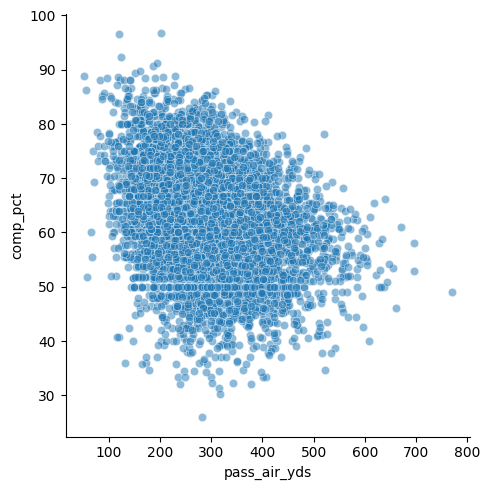

In [26]:
sns.relplot(
    x="pass_air_yds",
    y="comp_pct",
    data=df[df['pass_air_yds'] != 0],
    kind="scatter",
    alpha=0.5)        

In [25]:
# Calculate Pearson Correlation Coefficient
df[df['pass_air_yds'] != 0]['pass_air_yds'].corr(df['comp_pct'])

-0.30914319438226073

We can conclude that there is a slightly negative linear relationship between air yards and completion percentage. The longer a QB's throws are, the lower his completion percentage.

## Geno vs. The Field: 1999-2022
To start I will bring in the final table from [yesterday's](https://github.com/gfidanli/fantasy_football_analysis/blob/main/daily_analysis/day6.ipynb) analysis containing 979 player-season records and simplify the fields to the following:

| Field | Description |
| --- | --- |
| player_name | Name of player |
| season | NFL season |
| avg_comp_pct | The average completion percentage over the number of games the player played Weeks 1-7 of the season |
| tot_fantasy_pts | Player's total fantasy points over Weeks 1-7 |
| r_avg_comp_pct | Ranking of player's avg completion percentage over all QBs who played Weeks 1-7 from 1999-2022 and had at least 1 game with 25+ passing attempts
| r_fantasy_pts | Ranking of player's total fantasy points through over all QBs who played Weeks 1-7 from 1999-2022 and had at least 1 game with 25+ passing attempts  |

In [39]:
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        season,
        week,
        completions,
        attempts,
        ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
        passing_yards AS pass_yds,
        passing_tds AS pass_tds,
        interceptions AS int,
        passing_air_yards AS pass_air_yds,
        ROUND(fantasy_points,2) AS fantasy_pts
    FROM weekly 
    WHERE week < 8
        AND position = 'QB'
        AND season_type = 'REG'
        AND attempts >= 25
), aggregations AS (
    SELECT
       player_name,
       season,
       ROUND(AVG(comp_pct), 2) AS avg_comp_pct,
       ROUND(AVG(attempts), 2) AS avg_attempts,
       COUNT(*) AS num_games,
       SUM(fantasy_pts) AS tot_fantasy_pts
    FROM data
    GROUP BY player_name, season
), rankings AS (
    SELECT
        player_name,
        season,
        avg_comp_pct,
        avg_attempts,
        tot_fantasy_pts,
        num_games,
        ROW_NUMBER() OVER(ORDER BY avg_comp_pct DESC) AS r_avg_comp_pct,
        ROW_NUMBER() OVER(ORDER BY tot_fantasy_pts DESC) AS r_fantasy_pts
    FROM aggregations
)
SELECT
    player_name,
    season,
    avg_comp_pct,
    tot_fantasy_pts,
    r_avg_comp_pct,
    r_fantasy_pts
FROM rankings
WHERE num_games = 7
"""

pd.read_sql(query, conn).head(10)

,player_name,season,avg_comp_pct,tot_fantasy_pts,r_avg_comp_pct,r_fantasy_pts
0,Tom Brady,2007,75.13,186.10,11,4
1,Geno Smith,2022,73.45,123.68,19,95
2,Kyler Murray,2021,73.23,168.68,23,12
3,Peyton Manning,2013,72.47,194.30,27,1
4,Teddy Bridgewater,2020,72.06,118.30,33,122
5,Matt Ryan,2018,71.88,170.10,37,10
6,Drew Brees,2011,71.51,162.58,43,18
7,Dak Prescott,2019,71.43,153.22,44,27
8,Aaron Rodgers,2011,71.32,188.38,46,3
9,Matt Ryan,2019,71.15,141.20,48,47


So we have 115 player-season records where the player threw at least 25 times for each of the seven games from Weeks 1-7. Now let's add air yards.

In [33]:
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        season,
        week,
        completions,
        attempts,
        ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
        passing_yards AS pass_yds,
        passing_tds AS pass_tds,
        interceptions AS int,
        passing_air_yards AS pass_air_yds,
        ROUND(fantasy_points,2) AS fantasy_pts
    FROM weekly 
    WHERE week < 8
        AND position = 'QB'
        AND season_type = 'REG'
        AND attempts >= 25
), aggregations AS (
    SELECT
       player_name,
       season,
       ROUND(AVG(comp_pct), 2) AS avg_comp_pct,
       ROUND(AVG(attempts), 2) AS avg_attempts,
       ROUND(AVG(pass_air_yds),2) AS avg_pass_air_yds,
       COUNT(*) AS num_games,
       SUM(fantasy_pts) AS tot_fantasy_pts
    FROM data
    GROUP BY player_name, season
), rankings AS (
    SELECT
        player_name,
        season,
        avg_comp_pct,
        avg_attempts,
        avg_pass_air_yds,
        tot_fantasy_pts,
        num_games,
        ROW_NUMBER() OVER(ORDER BY avg_comp_pct DESC) AS r_avg_comp_pct,
        ROW_NUMBER() OVER(ORDER BY avg_pass_air_yds DESC) AS r_avg_pass_air_yds,
        ROW_NUMBER() OVER(ORDER BY tot_fantasy_pts DESC) AS r_fantasy_pts
    FROM aggregations
)
SELECT
    player_name,
    season,
    avg_comp_pct,
    avg_pass_air_yds,
    tot_fantasy_pts,
    r_avg_comp_pct,
    r_avg_pass_air_yds,
    r_fantasy_pts
FROM rankings
WHERE num_games = 7
"""

df_air_yds = pd.read_sql(query, conn)
df_air_yds.head(10)

,player_name,season,avg_comp_pct,avg_pass_air_yds,tot_fantasy_pts,r_avg_comp_pct,r_avg_pass_air_yds,r_fantasy_pts
0,Tom Brady,2007,75.13,228.29,186.10,11,612,4
1,Geno Smith,2022,73.45,250.14,123.68,19,536,95
2,Kyler Murray,2021,73.23,255.00,168.68,23,512,12
3,Peyton Manning,2013,72.47,333.29,194.30,27,135,1
4,Teddy Bridgewater,2020,72.06,231.14,118.30,34,603,122
5,Matt Ryan,2018,71.88,348.29,170.10,37,88,10
6,Drew Brees,2011,71.51,299.29,162.58,43,306,18
7,Dak Prescott,2019,71.43,338.71,153.22,44,117,27
8,Aaron Rodgers,2011,71.32,299.71,188.38,46,302,3
9,Matt Ryan,2019,71.15,345.57,141.20,48,96,47


Looking at the top 10 of this 115 player-season subset, Geno's performance is unremarkable from an air yards perspective. I wouldn't say it proves that he is "padding" his percentage completion stat with shorter throws, but his season doesn't stand out like Matt Ryan's 2018 start in which he **throws for ~100 yards more per game than Geno** and only has a ~1.5% worse completion percentage!